In [40]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from IPython.display import Latex
from datetime import datetime

import nbimporter
import spin_func as myfunc
from importlib import reload
reload(myfunc)

<module 'spin_func' from 'spin_func.ipynb'>

In [41]:
##########################
### System Hamiltonian ###
##########################

m = 1; n = 1; B = [0, 0, 1.4]; A = [[100]];
H_zn = Qobj(myfunc.z_hamiltonian(m, 0, B)) # Hz
H_ze = Qobj(np.kron(np.eye(2**m), myfunc.z_hamiltonian(0, n, B)))
H_hf = Qobj(myfunc.hf_hamiltonian(m, n, A))

H_neut = Qobj(np.kron(H_zn, np.eye(2**n)))+H_ze+H_hf
H_ion = H_zn

spinProj = Qobj(np.kron(np.eye(2**m), np.eye(2**n+1)[0:2**n]))
setProj = Qobj(np.kron(np.eye(2**m), np.eye(2**n+1)[-1]))

H = Qobj(spinProj.dag()*H_neut*spinProj+setProj.dag()*H_ion*setProj)

H_new = Qobj(np.diag(H.eigenstates()[0]))
evecs = H.eigenstates()[1]
l = len(np.diag(H.eigenstates()[0]))

In [42]:
############################
### Projection Operators ###
############################

basisT = Qobj(np.concatenate(([np.array(evecs[i]) for i in range(len(evecs))]), axis = 1))

state0 = Qobj(np.kron(fock_dm(2**m, 0), np.eye(2**n+1)))
state1 = Qobj(np.kron(fock_dm(2**m, 1), np.eye(2**n+1)))

electron_up = Qobj(np.kron(np.eye(2**(m)), fock_dm(2**n+1, 0)))
electron_down = Qobj(np.kron(np.eye(2**(m)), fock_dm(2**n+1, 1)))
electron_set = Qobj(np.kron(np.eye(2**(m)), fock_dm(2**n+1, 2)))

### Expressed in Eigenbasis ###

state0  = basisT.dag()*state0*basisT
state1  = basisT.dag()*state1*basisT

electron_up = basisT.dag()*electron_up*basisT
electron_down = basisT.dag()*electron_down*basisT
electron_set = basisT.dag()*electron_set*basisT

In [43]:
#######################
### Tunneling Times ###
#######################

set2down = basisT.dag()*Qobj(np.kron(np.eye(2**m), fock(3, 1)*fock(3, 2).dag()))*basisT

tau = 200e-6
tauRead_up_out = 80e-6
tauRead_down_in = 120e-6

Lread_down_in = np.sqrt(1/tauRead_down_in)*set2down
emptyOpt = 0
Lread = myfunc.outOp(m, evecs, [tauRead_up_out], emptyOpt)
Lread.append(Lread_down_in)
LiouRead = liouvillian(2*np.pi*H_new, Lread)

In [44]:
######################
### Time Evolution ###
######################

T = 1e-3
dt = 1e-6
N = int(T/dt)
t = np.arange(0, N)*dt

rho_init = basisT.dag()*fock_dm(6, 3)*basisT
rho_init = fock_dm(6, 5)
rho_vec = operator_to_vector(rho_init)
rho = []

expLiouRead = ((dt*LiouRead).expm())
for i in range(N):
    rho_vec = expLiouRead*rho_vec
    rho.append(vector_to_operator(rho_vec))

config0 = np.real(expect(state0, rho))
config1 = np.real(expect(state1, rho))
eSpin_up = np.real(expect(electron_up, rho))
eSpin_down = np.real(expect(electron_down, rho))
eSET = np.real(expect(electron_set, rho))

print('Finished')
print(config0[-1])
print(config1[-1])
print(1/tau)

Finished
0.9999967414776083
3.2522964496814286e-06
5000.0


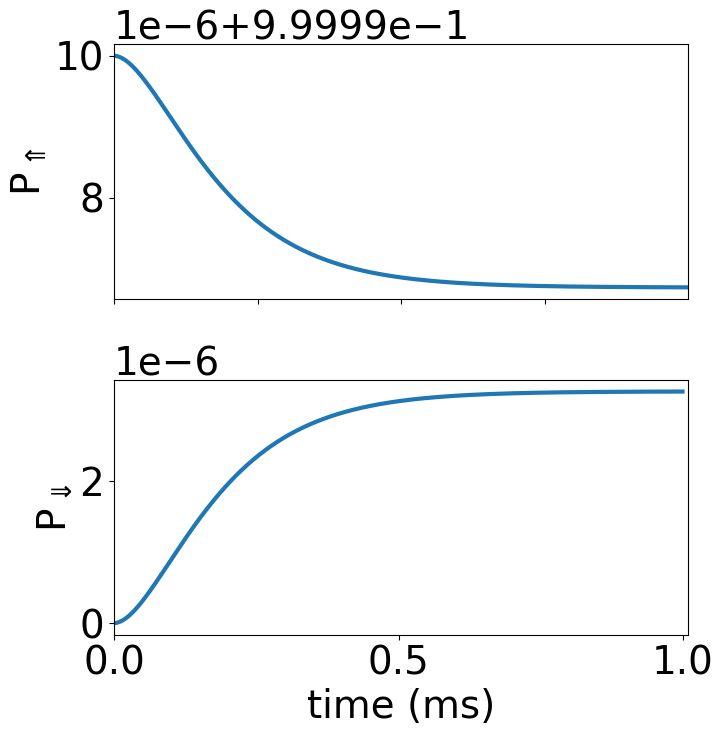

In [45]:
t = [1000*t[i] for i in range(N)]
fig = plt.figure()
ax = fig.add_subplot(211)
plt.plot(t, config0, linewidth = 3)
plt.ylabel('P$_\\Uparrow$')
ax.set_xticklabels([])
plt.xlim([t[0], t[-1]*1.001])
plt.rcParams.update({'font.size': 28})
plt.rc('ytick', labelsize=28)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.subplot(212)
plt.plot(t, config1, linewidth = 3)
plt.xlabel('time (ms)')
plt.ylabel('P$_\\Downarrow$')
plt.xlim([t[0], t[-1]*1.01])
plt.rcParams["figure.figsize"] = (8, 8)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()